# Real-Time Optimization Tutorial
## Simple quadratic benchmark

In [1]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import logging
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

from bunch import Bunch

from rto.models.simple_quadratic import SimpleQuadraticBenchmark
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform, generate_samples_lhs
from rto.experiment.analysis import ExperimentAnalyzer

MEMORY_DATABASE = "file::memory:?cache=shared"

## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [2]:
# Our complete model will be called the "plant"
plant = SimpleQuadraticBenchmark(name='SimpleQuadraticBenchmarkPlant')
# And the uncertain is the "model"
model = SimpleQuadraticBenchmark(name='SimpleQuadraticBenchmarkModel',k=[0,0])

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [106]:
# Define the input domain
grid_size = 50
g0 = 0.0
u1 = np.linspace(-1, 1.5, grid_size)
u2 = np.linspace(-1, 1, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g[:,0].reshape(xx.shape)

    return zz_cost, zz_g0

z_plant, g_plant = get_grid_values(plant, xx, yy)
z_model, g_model = get_grid_values(model, xx, yy)

g_plant_feasible = g_plant <= g0
g_model_feasible = g_model <= g0

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

/tmp/ipykernel_938/3961512938.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)
/tmp/ipykernel_938/3961512938.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


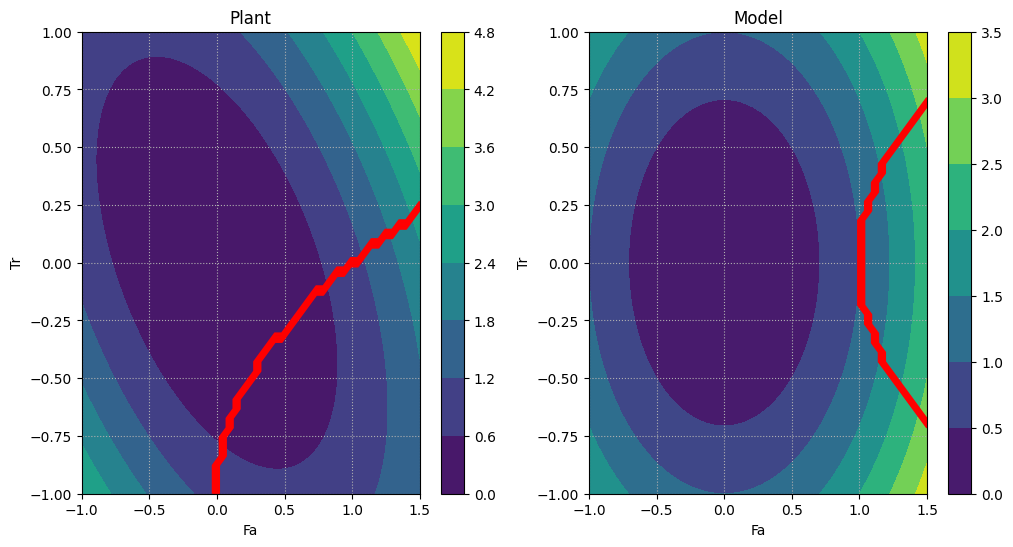

In [107]:
# Plot the decision surface
fig, ax = plt.subplots(1, 2, figsize=(12,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title):
    ax.contour(xx, yy, z_f, colors='red')
    CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

plot_decision_surface(fig, ax[0], xx, yy, g_plant_feasible, z_plant, 'Plant')
plot_decision_surface(fig, ax[1], xx, yy, g_model_feasible, z_model, 'Model')
fig.show()

In [5]:
ubx = [2, 2]
lbx = [-2, -2]
g = np.array([g0])

optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}}, backoff=0.0)
f_plant, u_plant ,_ = optimizer.run(plant, [])
f_model, u_model ,_ = optimizer.run(model, [])

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[ 0.37281267 -0.38971454], f*=0.14557619093346846
Model: u*=[ 1.00065377 -0.00252174], f*=1.0013143262450581


/tmp/ipykernel_938/3961512938.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


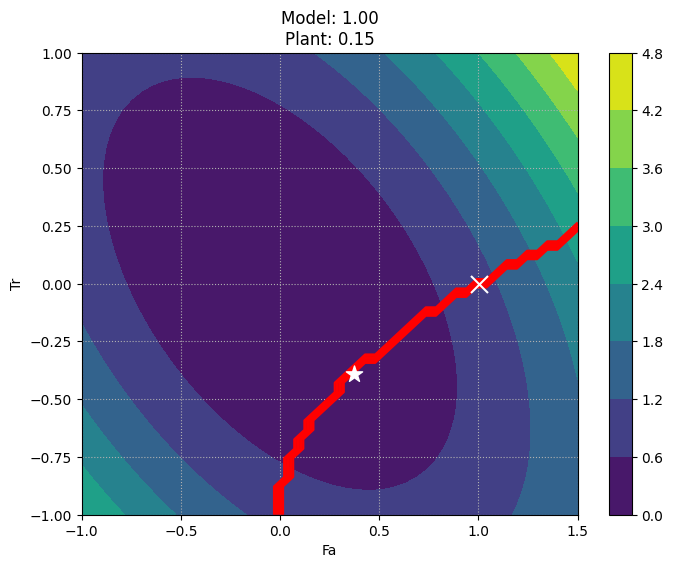

In [110]:
fig, ax = plt.subplots(figsize=(8,6))
model_cost = plant.get_objective(u_model)

plot_decision_surface(fig, ax, xx, yy, g_plant_feasible, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.scatter(u_model[0], u_model[1], c='w', marker='x', s=150, zorder=5)

/tmp/ipykernel_938/3961512938.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


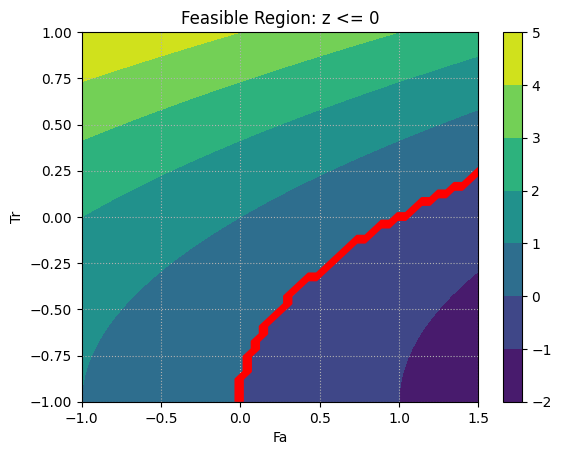

In [113]:
fig, ax = plt.subplots()
plot_decision_surface(fig, ax, xx, yy, g_plant_feasible, g_plant, 'Feasible Region: z <= 0')

[0.]


## Real-Time Optimization

RTO systems are capable of iteratively driving the system towards the optimum in spite of plant-model mismatch. The entire system is displayed in the image below:

In [141]:
# creates a memory database to be used in this tutorial
!python ../scripts/create_database.py -m

Creating database to file::memory:?cache=shared


In [8]:
# Define the system parameters
u_0 = u_model
iterations = 50
noise = None
initial_data_size = 5

# sample some initial data
u, y, measurements = generate_samples_uniform(model, plant, g, u_0, initial_data_size, noise=noise)
initial_data = Bunch(u=u, y=y, measurements=measurements)

adaptation_bay = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
# optimizer_bay = ModelBasedBayesianOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'hybrid', 'params': {'max_iter_init': 100}}, backoff=0.0)
optimizer_bay = ModelBasedBayesianOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de'}, backoff=0.0)

rto_bay = RTOBayesian(model, plant, optimizer_bay, adaptation_bay, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian', noise=noise)

Finally, we can run the RTO system. The last sampled initial operating point is used to start the system.

In [128]:
u_0_feas = u[-1]
for i in range(10):
    rto_id_bay = rto_bay.run(u_0_feas)
    print(f'Iter #{i}')


Iter #0
Iter #1
Iter #2
Iter #3
Iter #4
Iter #5
Iter #6
Iter #7
Iter #8
Iter #9


After the system stops after reaching the maximum amount of iterations, we can start analyzin the results. In order to do that, we need could use an instance of the `ExperimentAnalyzer` class.

In [129]:
import pandas as pd
# load the results
analyzer = ExperimentAnalyzer(MEMORY_DATABASE)
results = analyzer.load('MA-GP-Bayesian')
results_processed = analyzer.pre_process(results, f_plant, u_plant, g)


/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so canno

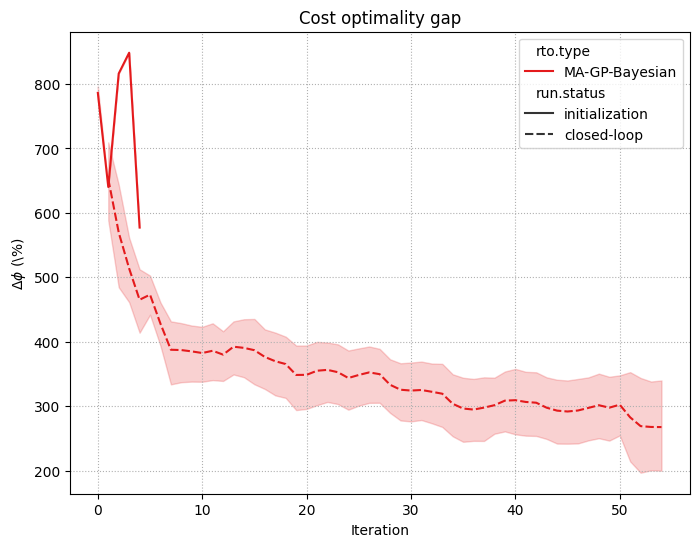

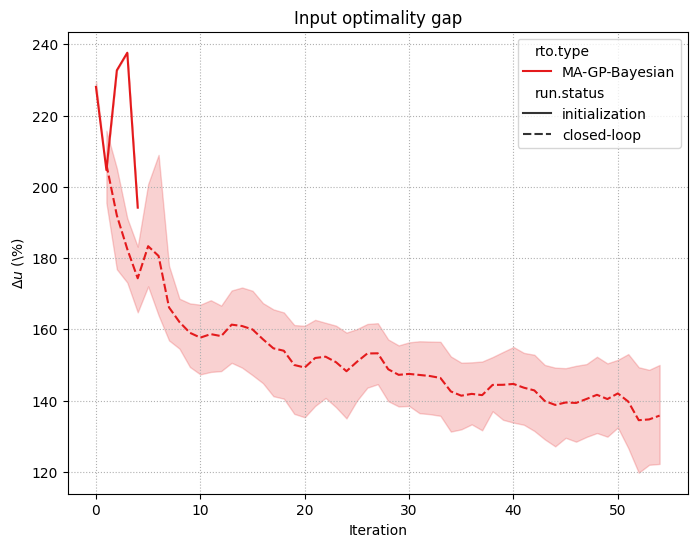

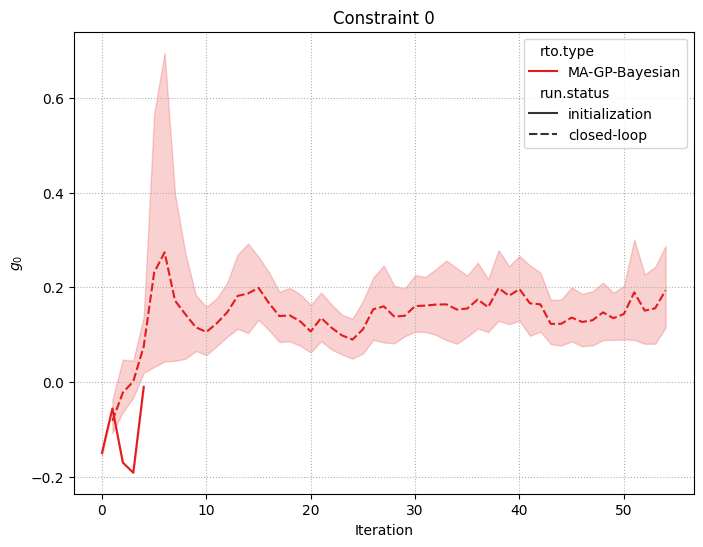

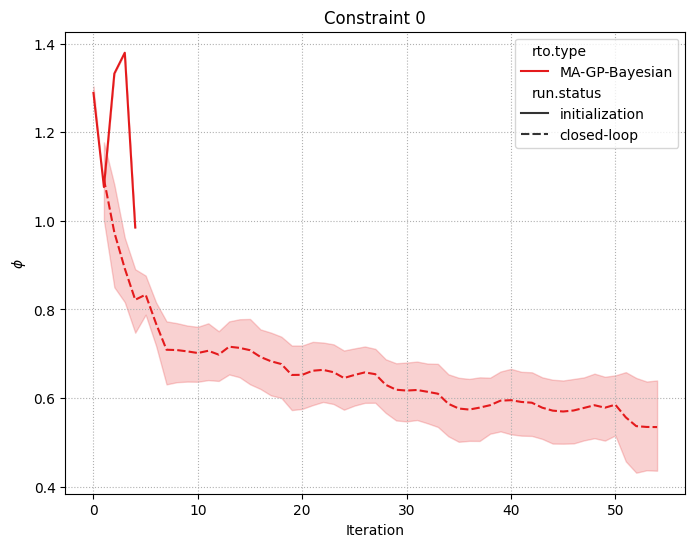

In [130]:
_ = analyzer.plot_by_iteration(results_processed, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed, 'cost_real', '$\phi$', 'Constraint 0',style='run.status', hue='rto.type')

/tmp/ipykernel_4408/2863116607.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


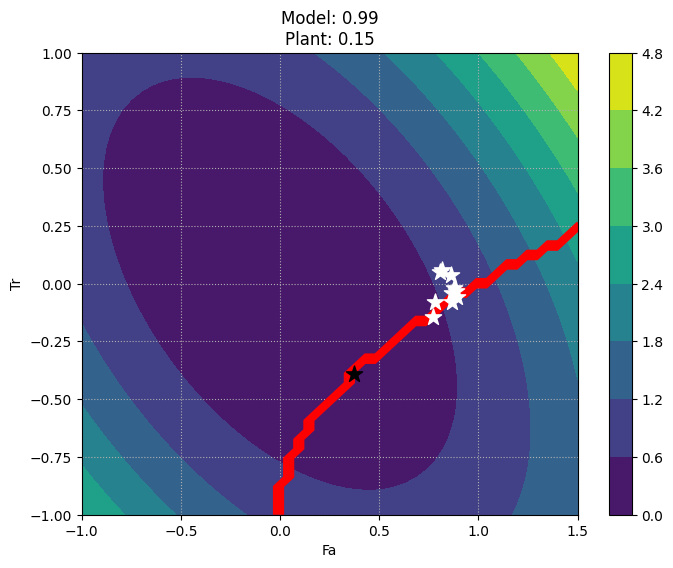

In [126]:
fig, ax = plt.subplots(figsize=(8,6))
plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

results_processed_last = results_processed[results_processed.iteration == 24]
ax.scatter(u_plant[0], u_plant[1], c='k', marker='*', s=150, zorder=5)

for key, row in results_processed_last.iterrows():
    ax.scatter(row['u'][0], row['u'][1], c='w', marker='*', s=150, zorder=5)

### Initial data choice 

In [135]:
logging.basicConfig(level=logging.DEBUG)

# Define the system parameters
u_0 = u_model
iterations = 50
noise = None
initial_data_size = 30

def run_data_choice_experiment(name, u_0, offset, repetitions):
    # sample some initial data
    u, y, measurements = generate_samples_uniform(model, plant, g, u_0, initial_data_size, offset=offset, noise=noise)
    initial_data = Bunch(u=u, y=y, measurements=measurements)

    adaptation_bay = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
    optimizer_bay = ModelBasedBayesianOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de'}, backoff=0.0)

    rto_bay = RTOBayesian(model, plant, optimizer_bay, adaptation_bay, iterations, db_file=MEMORY_DATABASE, name=f'MA-GP-Bayesian-{name}', noise=noise)

    fig, ax = plt.subplots()
    plot_decision_surface(fig, ax, xx, yy, g_plant_feasible, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')
    ax.scatter(u[:,0], u[:,1], c='w', marker='*', s=150, zorder=5)
    
    u_0_feas = u[-1]
    for i in range(repetitions):
        rto_id_bay = rto_bay.run(u_0_feas)
        print(f'Iter #{i}')
    return rto_bay

#### Data close the constraints

/tmp/ipykernel_938/3961512938.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


Iter #0


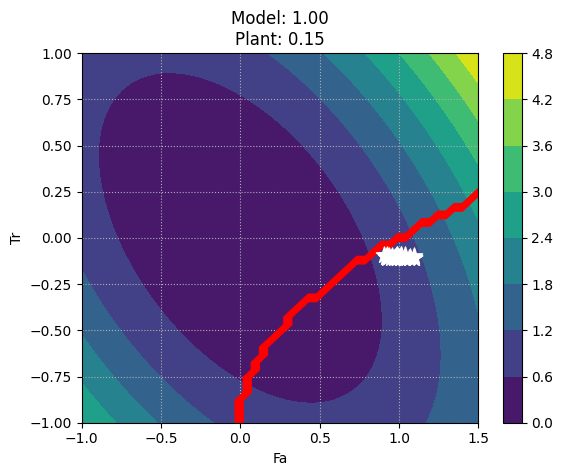

In [142]:
rto = run_data_choice_experiment('CloseToConstraint', [1, -0.1], 0.9, 1)

In [134]:
x = [1.0, 0]
g_model = model.get_constraints(x).reshape(-1,)
adaptation_x = rto.adaptation_strategy.get_adaptation(np.array(x).reshape(1,-1), return_std=True).get()
print(ModelBasedBayesianOptimizer.constraint_probability(g, g_model, adaptation_x))
print(ModelBasedBayesianOptimizer.ei_acquisition(model.get_objective(x), adaptation_x, 1.0))

[0.74530146]
0.022930637295480998


#### Data far from the constraints

/tmp/ipykernel_938/3961512938.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


Iter #0


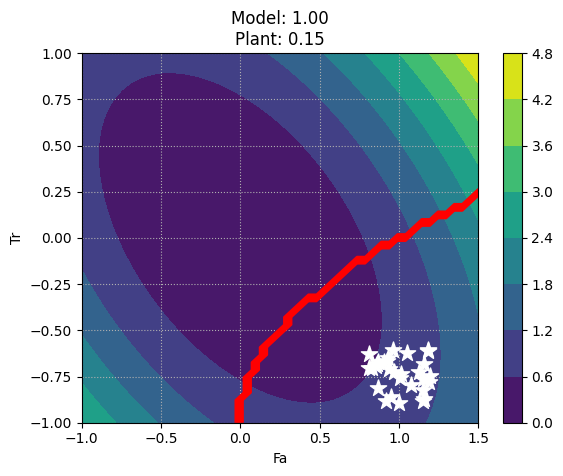

In [143]:
rto = run_data_choice_experiment('FarFromConstraint', [1, -0.75], 0.8, 1)

#### Mixed data locations

/tmp/ipykernel_938/3961512938.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


Iter #0


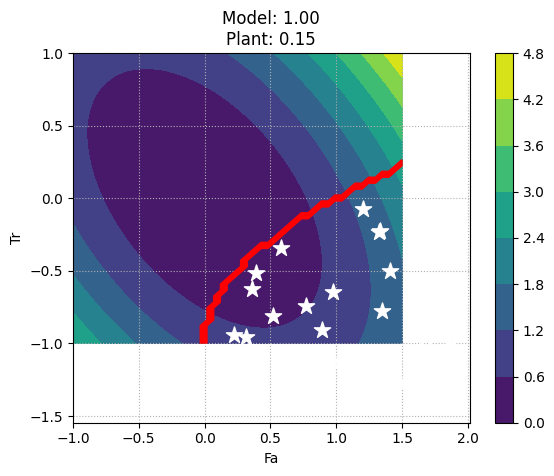

In [144]:
rto = run_data_choice_experiment('MixedLocations', [1, -0.75], 0.1, 1)

#### Comparison

In [145]:
import pandas as pd
analyzer = ExperimentAnalyzer(MEMORY_DATABASE)
results_ctc = analyzer.load('MA-GP-Bayesian-CloseToConstraint')
results_ffc = analyzer.load('MA-GP-Bayesian-FarFromConstraint')
results_mix = analyzer.load('MA-GP-Bayesian-MixedLocations')

results_processed_ctc = analyzer.pre_process(results_ctc, f_plant, u_plant, g)
results_processed_ffc = analyzer.pre_process(results_ffc, f_plant, u_plant, g)
results_processed_mix = analyzer.pre_process(results_mix, f_plant, u_plant, g)

results_all = pd.concat([results_processed_ctc, results_processed_ffc, results_processed_mix], ignore_index=True)

/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so canno

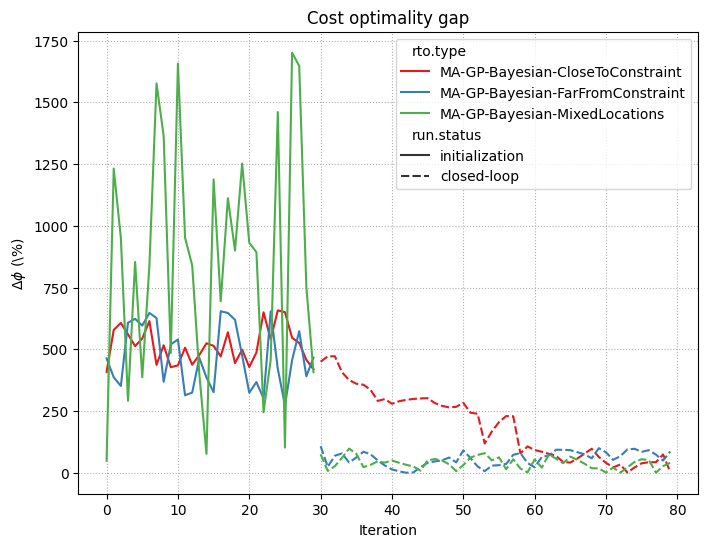

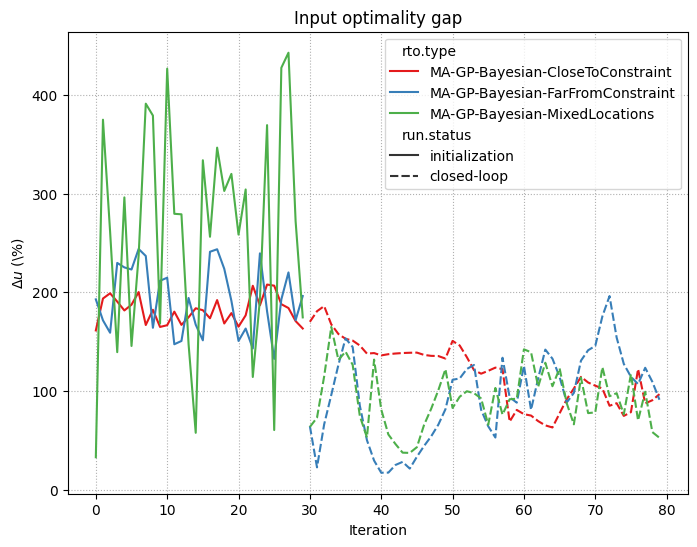

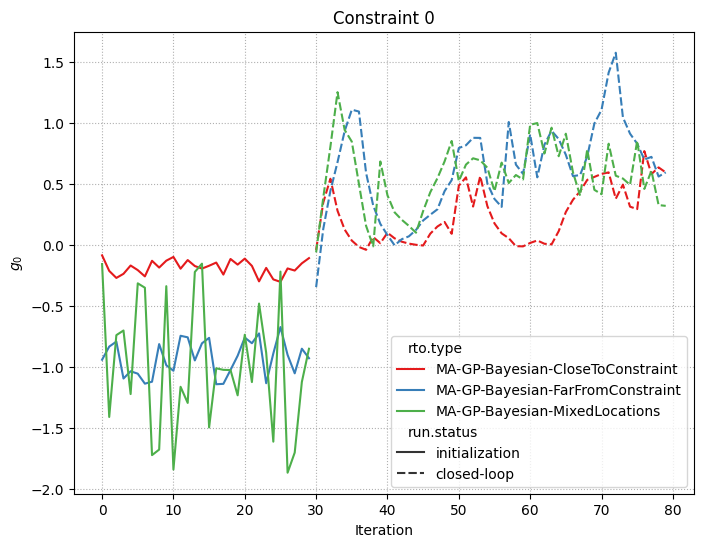

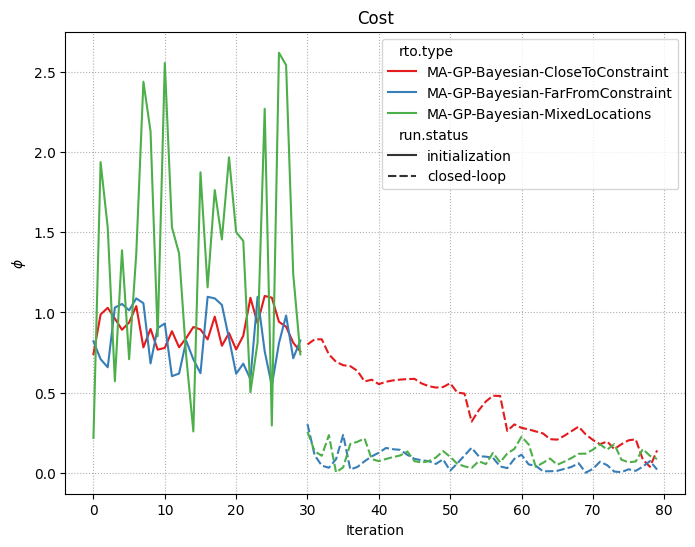

In [146]:
_ = analyzer.plot_by_iteration(results_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'cost_real', '$\phi$', 'Cost',style='run.status', hue='rto.type')

/tmp/ipykernel_938/2863116607.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, ax=ax)


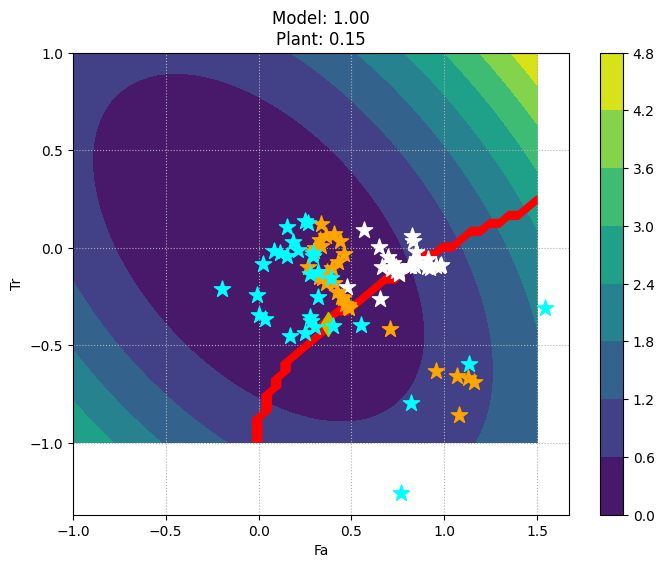

In [91]:
fig, ax = plt.subplots(figsize=(8,6))
plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

results_all_last = results_all[results_all.iteration == iterations-1]
ax.scatter(u_plant[0], u_plant[1], c='y', marker='d', s=150, zorder=5)

color_map = {'MA-GP-Bayesian-CloseToConstraint': 'white', 'MA-GP-Bayesian-FarFromConstraint': 'orange', 'MA-GP-Bayesian-MixedLocations': 'cyan'}
for key, row in results_all.iterrows():
    ax.scatter(row['u'][0], row['u'][1], marker='*', c=color_map[row['rto.type']], s=150, zorder=5, label=row['rto.type'])